<div>

# Zachary's Karate Club Graph Analysis

<div>
Libraries Used

In [381]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import precision_recall_curve, auc
import random

<div>
Part 1 (Graph Exploration)

    a) Graph Construction and Visualization

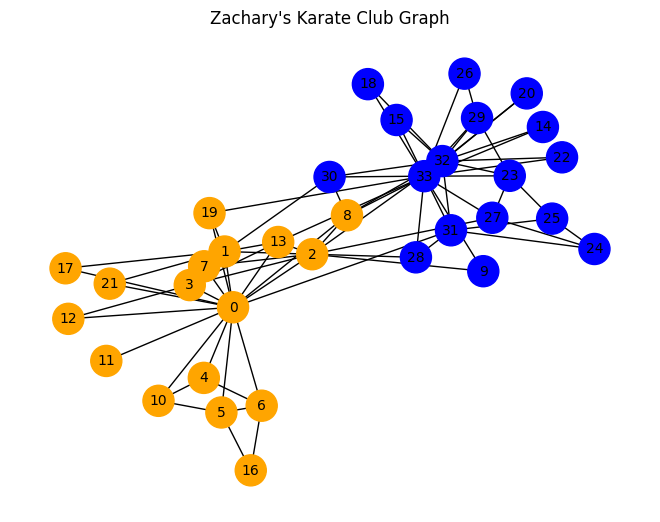

In [382]:
# graph making
Graph = nx.karate_club_graph()
# coloring
colors = ['orange' if Graph.nodes[node]['club'] == 'Mr. Hi' else 'blue' for node in Graph.nodes]
nx.draw(Graph, with_labels=True, node_color=colors, node_size=500, font_size=10)
plt.title("Zachary's Karate Club Graph")
plt.show()

<div>

    b) Exploring Graph Features

In [383]:
# number of edges
num_edges = Graph.number_of_edges()
# number of nodes
num_nodes = Graph.number_of_nodes()
# median of degree
avg_degree = sum(dict(Graph.degree()).values()) / num_nodes
# clustering coefficients
clustering_coefficient = nx.average_clustering(Graph)
print(f"number of nodes: {num_nodes}")
print(f"number of edges: {num_edges}")
print(f"median of degree: {avg_degree:.2f}")
print(f"clustering coefficients: {clustering_coefficient:.2f}")

number of nodes: 34
number of edges: 78
median of degree: 4.59
clustering coefficients: 0.57


<div>
Part 2 (Vertex Feature Extraction and Clustering)

    a) Obtaining embeddings for each vertex using the node2vec algorithm

In [384]:
# Embedding making
node2vec = Node2Vec(Graph, dimensions=2, walk_length=10, num_walks=100, workers=1)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# embedding for each node
node_embeddings = np.array([model.wv[str(node)] for node in Graph.nodes])
node_embeddings

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 912.20it/s]


array([[ 0.05306216,  1.4548795 ],
       [-0.15022253,  1.202772  ],
       [-0.30178347,  1.056778  ],
       [-0.10295346,  1.2809701 ],
       [ 0.49208182,  2.065551  ],
       [ 0.7864567 ,  2.8137195 ],
       [ 0.7420018 ,  2.6458523 ],
       [-0.16017666,  1.2251272 ],
       [-0.80104   ,  0.7913125 ],
       [-0.9540321 ,  0.7396388 ],
       [ 0.62670493,  2.2960079 ],
       [ 0.0838981 ,  1.4355918 ],
       [ 0.01459695,  1.3796146 ],
       [-0.2282877 ,  1.1225747 ],
       [-1.6764177 ,  0.65477425],
       [-1.6945138 ,  0.6606374 ],
       [ 0.8719857 ,  2.8977308 ],
       [ 0.10634867,  1.48722   ],
       [-1.4561088 ,  0.6424447 ],
       [-0.28402993,  1.0794787 ],
       [-1.6544966 ,  0.6589548 ],
       [ 0.11051885,  1.412072  ],
       [-1.5846401 ,  0.6564835 ],
       [-2.0035434 ,  0.6599425 ],
       [-1.6243917 ,  0.6602494 ],
       [-1.7764426 ,  0.6499188 ],
       [-2.005167  ,  0.6488643 ],
       [-1.5166832 ,  0.6440509 ],
       [-1.0213873 ,

<div>

    b) Clustering using k-means

In [385]:
kmeans = KMeans(n_clusters=2, random_state=42)  # k=2 because we have 2 labels
kmeans.fit(node_embeddings)
kmeans.labels_

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<div>

    c) Visualization of clustering by dimensionality reduction of each vertex's embeddings using the t-SNE algorithm

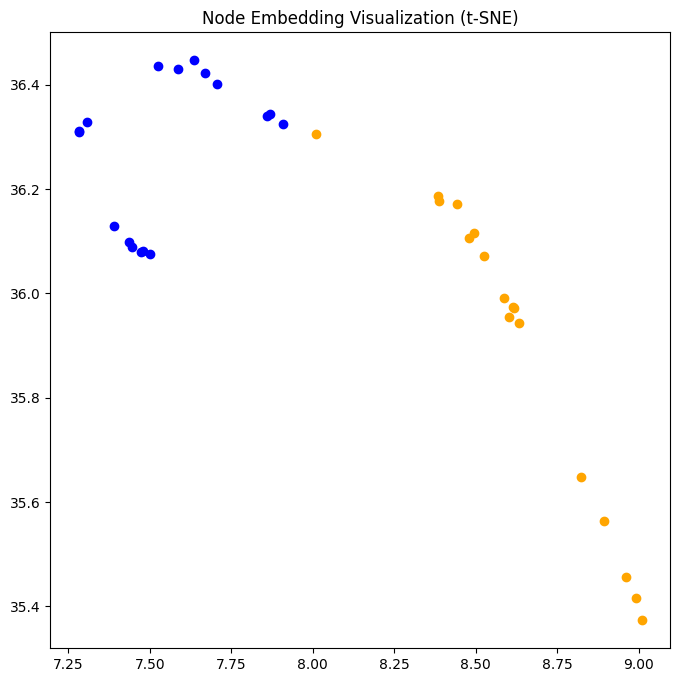

In [386]:
# demention reduction
tsne = TSNE(n_components=2, random_state=42)
low_dim_embeddings = tsne.fit_transform(np.array(node_embeddings))

# visualizing
plt.figure(figsize=(8, 8))
for i, coord in enumerate(low_dim_embeddings):
    plt.scatter(coord[0], coord[1], c=colors[int(i)], label=i)
plt.title("Node Embedding Visualization (t-SNE)")
plt.show()

<div>

    d) Calculation of clustering purity according to actual labels (club)

In [387]:
def clustering_purity(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The length of true_labels and predicted_labels must be the same.")


    clusters = np.unique(predicted_labels)
    total_samples = len(true_labels)
    correct_predictions = 0

    # true samples in each clusters
    for cluster in clusters:
        # values  for this cluster
        indices = np.where(predicted_labels == cluster)[0]
        cluster_true_labels = true_labels[indices]

        # finding the most used label
        most_common_label, count = Counter(cluster_true_labels).most_common(1)[0]
        correct_predictions += count

    # purity computation
    purity = correct_predictions / total_samples
    return purity

<div>

## Description of clustering_purity function

Clustering Purity Calculation

true_labels: Array of actual labels

predicted_labels: Array of predicted labels (clustering)

return: Clustering purity value

In [388]:
true_labels = np.array([1 if Graph.nodes[node]['club'] == 'Mr. Hi' else 0 for node in Graph.nodes])
predicted_labels = np.array(kmeans.labels_)
purity = clustering_purity(true_labels,predicted_labels)
print(f"Purity: {purity:.2f}")

Purity: 0.97


<div>

# Part 3 (Edge Prediction)

- a) Removing 20% of the edges and placing them in the test set

In [389]:
# test & train datas
edges = list(Graph.edges)
random.shuffle(edges)# for randomness
test_size = int(0.2 * len(edges)) # 20% removing

test_edges = edges[:test_size]
train_edges = edges[test_size:]

# train graph
Graph_train = Graph.copy()
Graph_train.remove_edges_from(test_edges)

<div>

- b) Edge prediction in the training graph (the remaining graph after removing test edges) using the Adamic-Adar similarity measure

In [390]:
# Adamic-Adar
predicted_scores = []
true_labels = []

# probablity edges
for u, v in nx.non_edges(Graph_train):
    # computing Adamic-Adar score
    score = sum(1 / np.log(len(list(Graph_train.neighbors(w))))
                for w in nx.common_neighbors(Graph_train, u, v) if len(list(Graph_train.neighbors(w))) > 1)
    predicted_scores.append(score)
    true_labels.append((u, v) in test_edges)

predicted_scores


[0.9102392266268373,
 0.5138983423697507,
 0.5138983423697507,
 0,
 0,
 0.9102392266268373,
 0,
 0,
 0.45511961331341866,
 0,
 0,
 0.5581106265512472,
 0.5581106265512472,
 0,
 0.5138983423697507,
 0.5581106265512472,
 0,
 0.45511961331341866,
 1.072008968920998,
 1.279458146995729,
 0.3898712452512801,
 0,
 0.3898712452512801,
 1.2352458628142324,
 0.5138983423697507,
 0.3898712452512801,
 0.3898712452512801,
 1.011206179810892,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5138983423697507,
 0,
 0,
 0.3898712452512801,
 1.2352458628142324,
 1.4426950408889634,
 0.3898712452512801,
 0,
 0.3898712452512801,
 0.8449908585646988,
 0.3898712452512801,
 0.3898712452512801,
 1.011206179810892,
 1.4663257931243106,
 0.43429448190325176,
 0.43429448190325176,
 0,
 0.8449908585646988,
 0,
 0.8449908585646988,
 0.43429448190325176,
 0.45511961331341866,
 0,
 1.344533708530089,
 0.9102392266268373,
 0,
 0,
 0,
 0.43429448190325176,
 1.6107616156611522,
 0.8241657271545318,
 2.598337043236697,
 0.38

<div>

- c) Visualization of the accuracy of predicted edges by displaying the original graph

In [391]:
def visualize_predictions(G, G_train, test_edges, predicted_scores, threshold=0.1):
    pos = nx.spring_layout(G)  # determining positions

    # visualizing the actual graph
    nx.draw(G, pos, with_labels=True, edge_color='gray', node_color='lightblue')

    # visualizing edges
    for idx, (u, v) in enumerate(test_edges):
        if predicted_scores[idx] > threshold:  
            color = 'green'
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color)
        else:
            color = 'red'
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color)

    # plt.show()

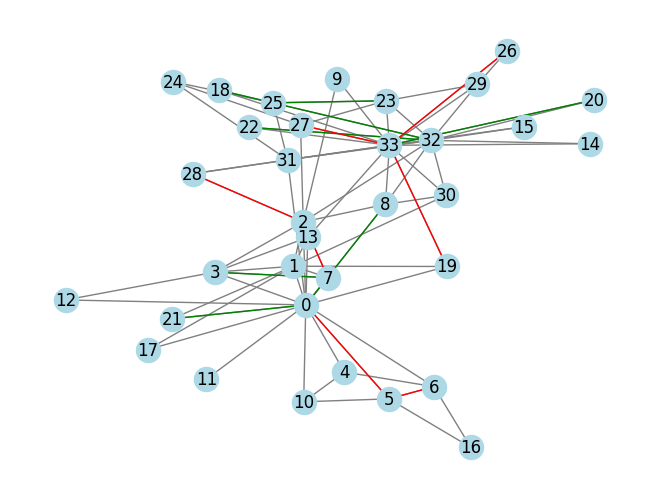

In [392]:
# visualization
visualize_predictions(Graph, Graph_train, test_edges, predicted_scores, threshold=0.1)

<div>

- d) Evaluation of prediction by plotting the Precision-Recall curve

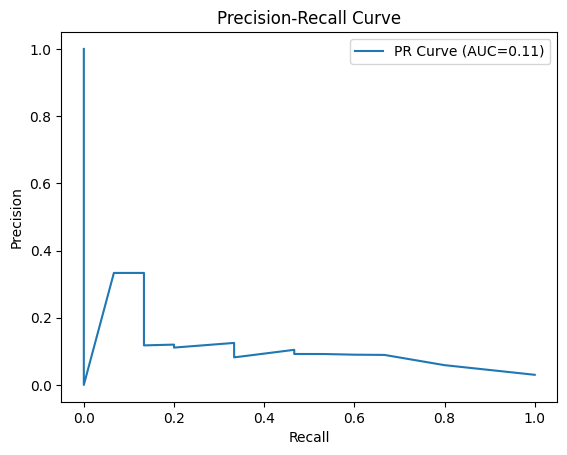

In [393]:
# Precision-Recall computing
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_scores)
pr_auc = auc(recall, precision)

# visualizing Precision-Recall plot
plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()